In [51]:
import torch
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from models import timer_xl

In [52]:
args = argparse.Namespace()
args.input_token_len = 480  
args.output_token_len = 480 
args.d_model = 1024
args.n_heads = 8
args.e_layers = 4  
args.d_ff = 2048
args.dropout = 0.1
args.activation = 'relu'
args.use_norm = True
args.flash_attention = False
args.covariate = False
args.output_attention = False
model = timer_xl.Model(args)

model.load_state_dict(torch.load('/home/ubuntu/OpenLTM-Nego/checkpoints/forecast_negotiation_timer_xl_Negotiation_sl1920_it480_ot480_lr0.0001_bt256_wd0_el4_dm1024_dff2048_nh8_cosTrue_test_0/checkpoint.pth')) 

<All keys matched successfully>

In [53]:
df = pd.read_csv("./data/oracle/train/ParetoWalkerAgent_SAGA_Domain11_test_B.csv")
df.drop("ds", axis=1, inplace=True)

In [54]:
def forecast(model, input_data, prediction_length, output_token_len=480):
    """
    Timer-XL's actual implementation
    """
    inference_steps = prediction_length // output_token_len
    remainder = prediction_length - inference_steps * output_token_len
    if remainder != 0:
        inference_steps += 1
    
    pred_y = []
    current_input = input_data.clone()
    
    for j in range(inference_steps):
        if len(pred_y) != 0:
            # Slide window: remove old tokens, add new predictions
            current_input = torch.cat([
                current_input[:, output_token_len:, :], 
                pred_y[-1]
            ], dim=1)
        
        with torch.no_grad():
            outputs = model(current_input, None, None)
            # Use ALL output tokens, not just the first!
            pred_y.append(outputs[:, -output_token_len:, :])
    
    # Concatenate all predictions
    forecast = torch.cat(pred_y, dim=1)
    
    # Trim to exact length if needed
    if remainder != 0:
        forecast = forecast[:, :-output_token_len + remainder, :]
    
    return forecast

In [55]:
def get_prediction_data(df, lookback_length, prediction_length, start_idx=None):
    """
    Get input window and make predictions with Timer-XL

    Args:
        df: DataFrame with time series data
        lookback_length: Number of timesteps to use as input
        prediction_length: Number of timesteps to predict
        start_idx: Starting index for the input window (if None, uses tail)

    Returns:
        dict with input_data, predictions, input_values, actual_values, and metadata
    """
    numeric_df = df.select_dtypes(include=[np.number])

    if start_idx is None:
        # Use the last available data - but we need enough for both input and target
        if len(numeric_df) < lookback_length + prediction_length:
            # Not enough data for both input and target, use what we can
            input_values = numeric_df.tail(lookback_length).values
            actual_values = None
        else:
            # We have enough data, take input and the NEXT prediction_length values as target
            total_needed = lookback_length + prediction_length
            data_window = numeric_df.tail(total_needed).values
            input_values = data_window[:lookback_length]
            actual_values = data_window[lookback_length:]
    else:
        # Use specific window
        end_idx = start_idx + lookback_length
        input_values = numeric_df.iloc[start_idx:end_idx].values

        # Get actual values for comparison if available
        actual_end_idx = end_idx + prediction_length
        if actual_end_idx <= len(numeric_df):
            actual_values = numeric_df.iloc[end_idx:actual_end_idx].values
        else:
            actual_values = None

    # Convert to tensor and make prediction
    input_tensor = torch.tensor(input_values, dtype=torch.float32).unsqueeze(0)
    prediction_tensor = forecast(model, input_tensor, prediction_length)
    predictions = prediction_tensor[0].cpu().numpy()  # Remove batch dimension

    return {
        'input_data': input_values,
        'predictions': predictions,
        'actual_values': actual_values,
        'input_tensor': input_tensor,
        'prediction_tensor': prediction_tensor,
        'column_names': numeric_df.columns.tolist(),
        'lookback_length': lookback_length,
        'prediction_length': prediction_length
    }

In [56]:
len(df)

8867

In [57]:
start_idx = 0    
lookback_length = 480 * 4
prediction_length = min(480 * 3, len(df)-lookback_length-start_idx)

result = get_prediction_data(df, lookback_length, prediction_length, start_idx)
print(f"Columns: {result['column_names']}")
print(f"Input shape: {result['input_data'].shape}")
print(f"Prediction shape: {result['predictions'].shape}")
if result['actual_values'] is not None:
    print(f"Actual values shape: {result['actual_values'].shape}")
else:
    print("No actual values available for comparison")

Columns: ['AgentUtility', 'Move_Cumulative_Concession', 'Move_Cumulative_Fortunate', 'Move_Cumulative_Nice', 'Move_Cumulative_Selfish', 'Move_Cumulative_Silent', 'Move_Cumulative_Unfortunate', 'y']
Input shape: (1920, 8)
Prediction shape: (1440, 8)
Actual values shape: (1440, 8)


In [58]:
# Show predictions as DataFrame
pd.DataFrame(result['predictions'], columns=result['column_names'])

,AgentUtility,Move_Cumulative_Concession,Move_Cumulative_Fortunate,Move_Cumulative_Nice,Move_Cumulative_Selfish,Move_Cumulative_Silent,Move_Cumulative_Unfortunate,y
0,0.318122,0.182026,0.011443,0.019788,0.209028,0.524068,0.025314,0.952422
1,0.311588,0.180366,0.011605,0.018058,0.207324,0.525924,0.023166,0.952962
2,0.317930,0.188664,0.009934,0.025712,0.205921,0.532039,0.025232,0.955115
3,0.314323,0.184250,0.014165,0.023281,0.212673,0.534900,0.026378,0.953036
4,0.317778,0.184245,0.012710,0.025055,0.199584,0.530632,0.021961,0.949498
...,...,...,...,...,...,...,...,...
1435,0.381342,0.190774,0.037908,0.019166,0.198246,0.526072,0.020922,0.920661
1436,0.374239,0.192928,0.039876,0.020943,0.198150,0.527891,0.021930,0.923423
1437,0.384024,0.191075,0.038263,0.019185,0.197541,0.527499,0.021507,0.921291
1438,0.379868,0.191600,0.036893,0.020133,0.197879,0.525293,0.020890,0.921308


In [59]:
def plot_prediction_comparison(result, column_name, figsize=(12, 6)):
    """
    Plot input sequence, predictions, and actual values for a specific column

    Args:
        result: Output from get_prediction_data()
        column_name: Name of the column to plot
        figsize: Figure size tuple
    """
    if column_name not in result['column_names']:
        raise ValueError(f"Column '{column_name}' not found in {result['column_names']}")

    col_idx = result['column_names'].index(column_name)

    # Extract data
    input_values = result['input_data'][:, col_idx]
    predicted_values = result['predictions'][:, col_idx]

    # Create time indices
    lookback_length = result['lookback_length']
    prediction_length = result['prediction_length']

    input_indices = np.arange(lookback_length)
    prediction_indices = np.arange(lookback_length, lookback_length + prediction_length)

    # Plot
    plt.figure(figsize=figsize)

    # Plot input sequence
    plt.plot(input_indices, input_values, label='Input Sequence', color='blue', linewidth=2)

    # Plot predictions
    plt.plot(prediction_indices, predicted_values, label='Timer-XL Prediction', color='red', linewidth=2)

    # Plot actual values if available
    if result['actual_values'] is not None:
        actual_values = result['actual_values'][:, col_idx]
        actual_indices = prediction_indices[:len(actual_values)]
        plt.plot(actual_indices, actual_values, label='Actual Target', color='green', linewidth=2, alpha=0.5)

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title(f'Timer-XL Prediction vs Actual for "{column_name}" column')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

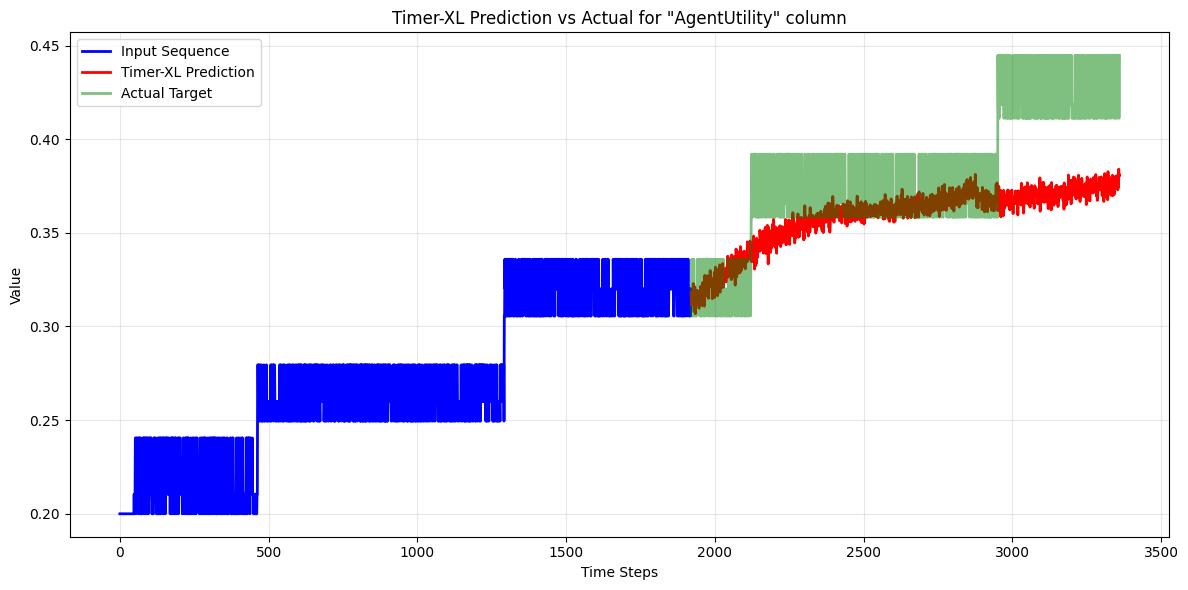

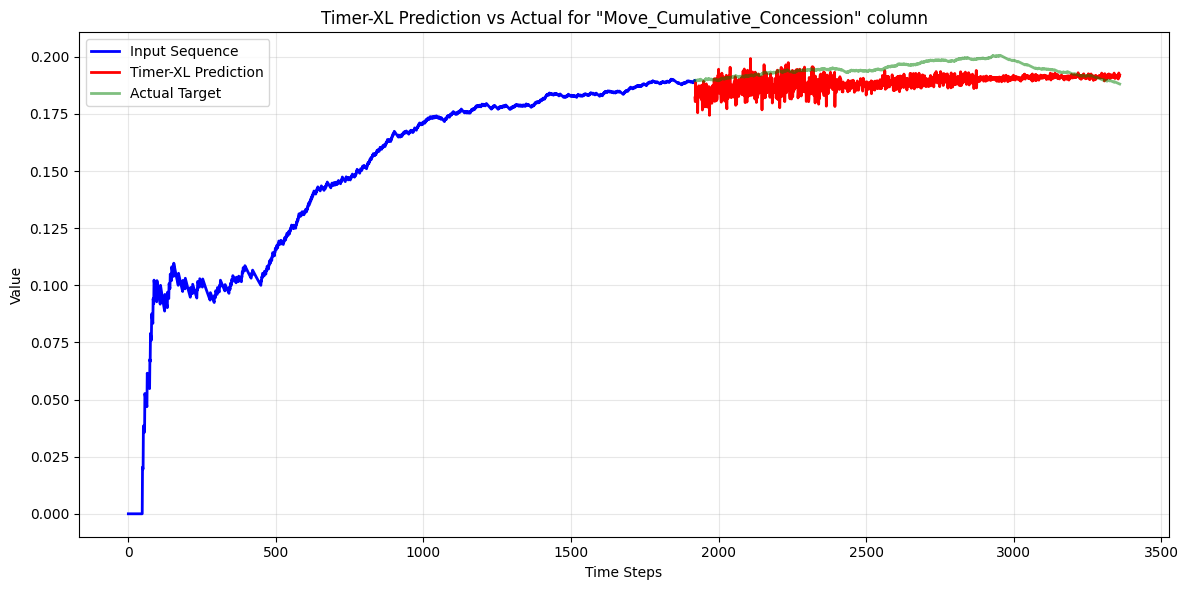

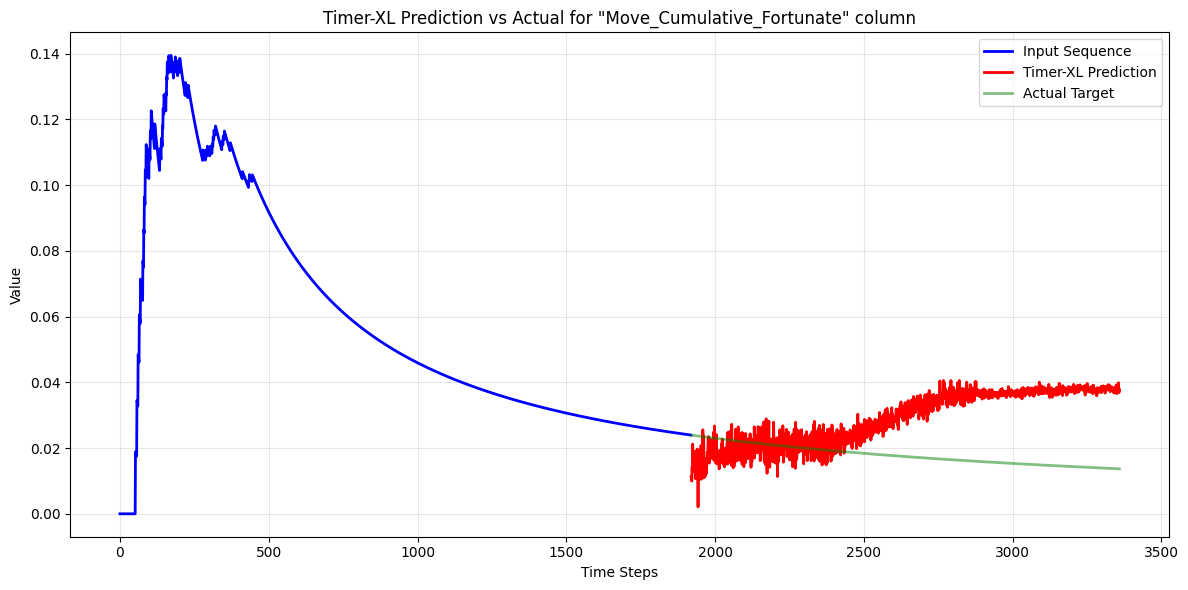

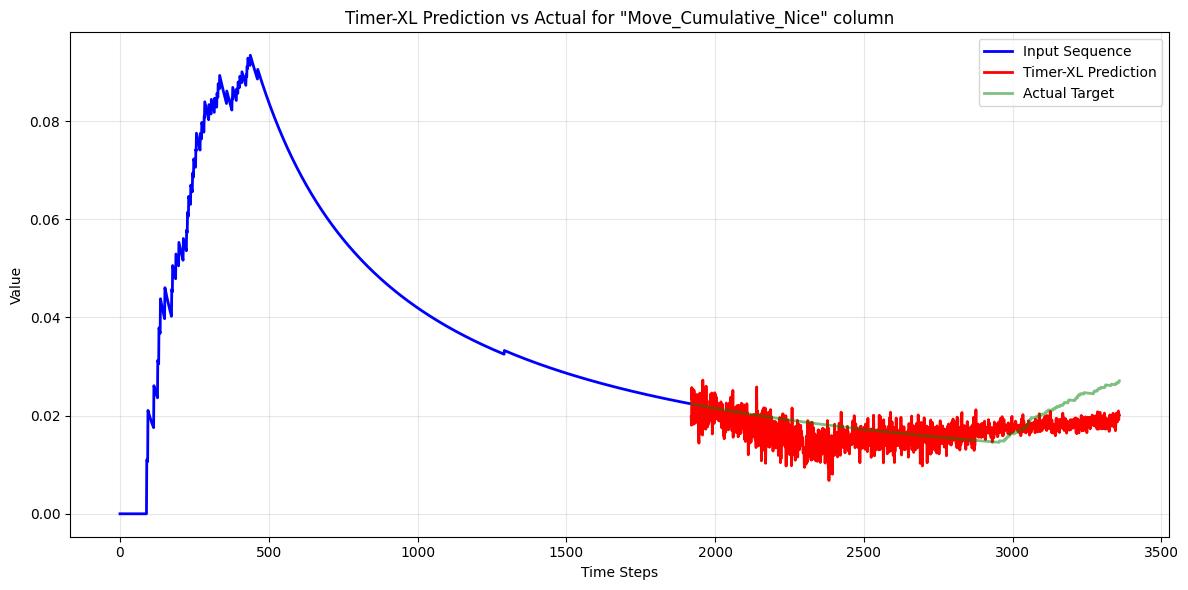

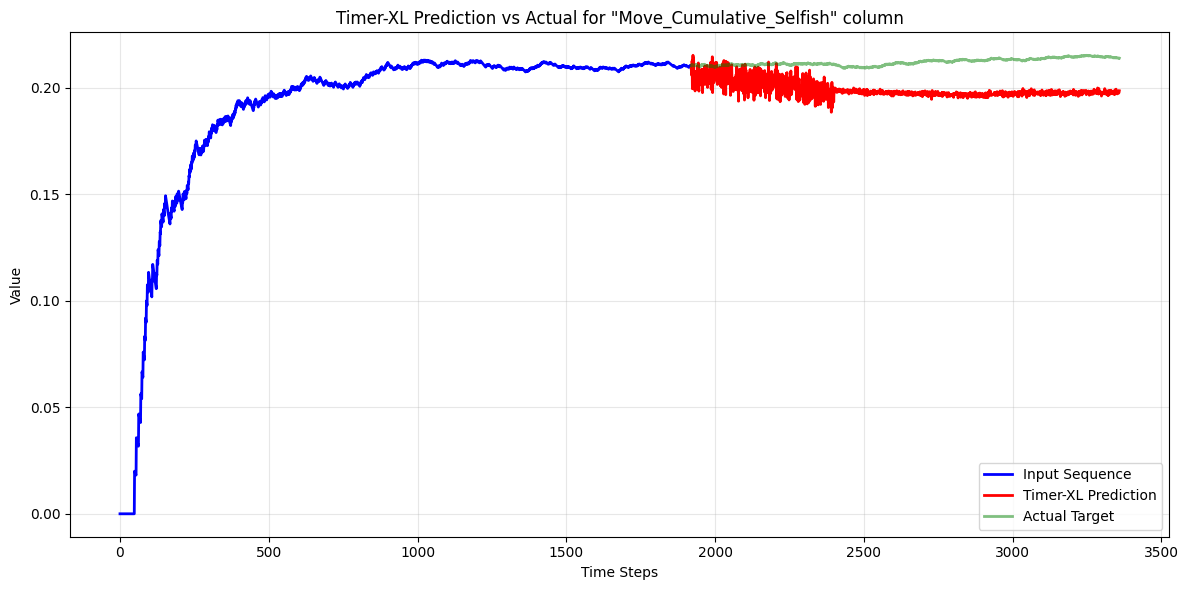

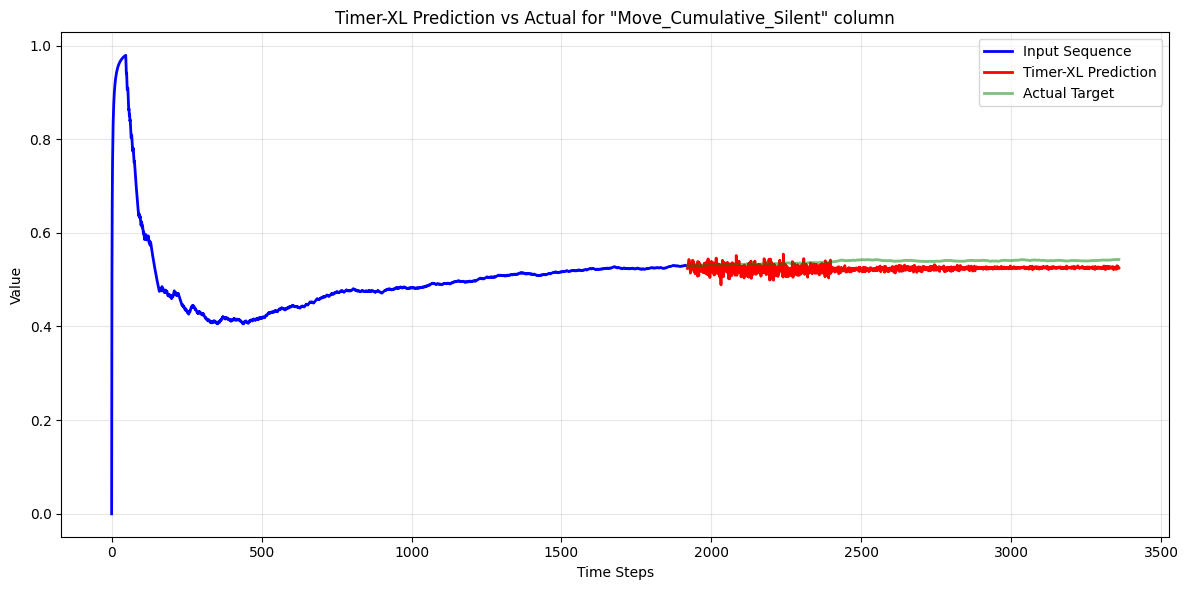

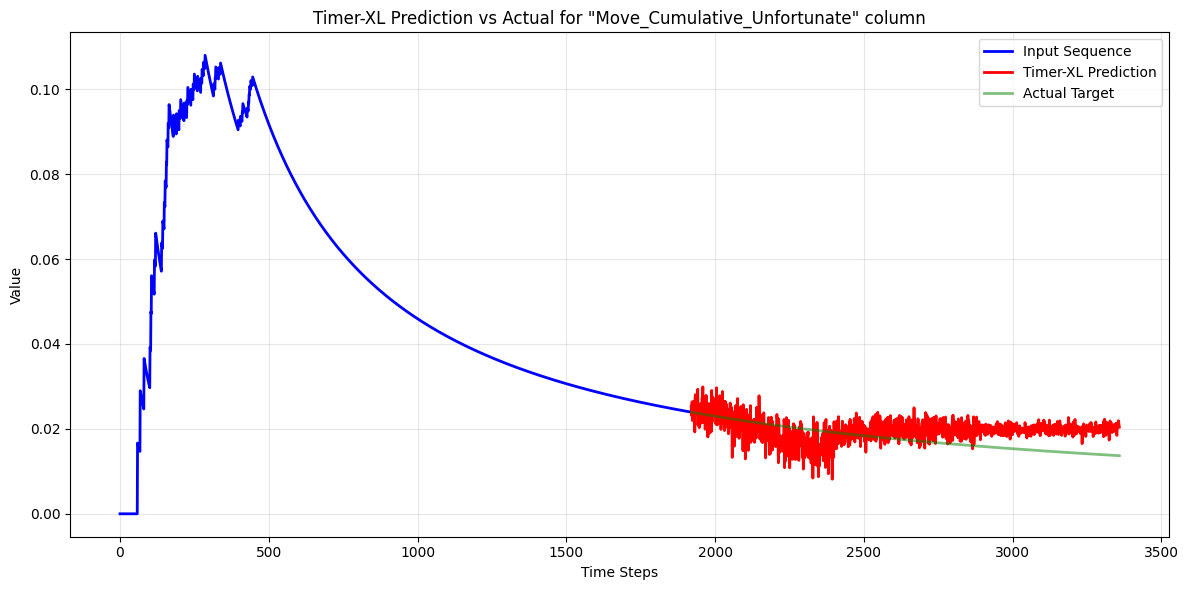

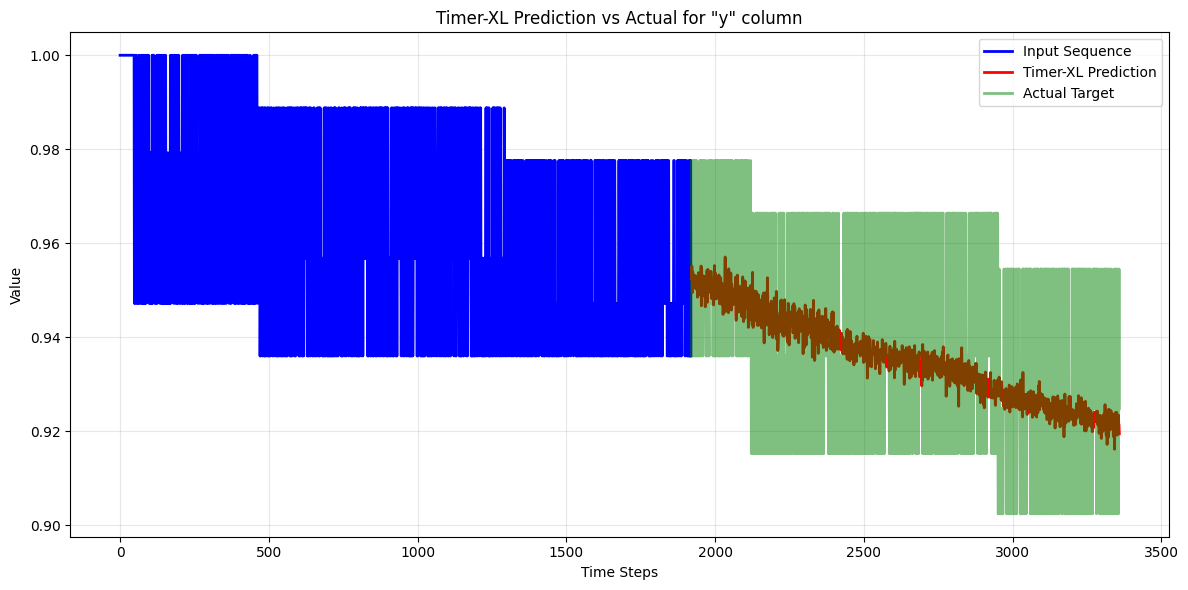

In [60]:
for column_name in result['column_names']:
    plot_prediction_comparison(result, column_name)